In [14]:
!pip install stable-baselines3 gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.3 MB/s eta 0:00:00


model-free

Starting TD3 agent training...


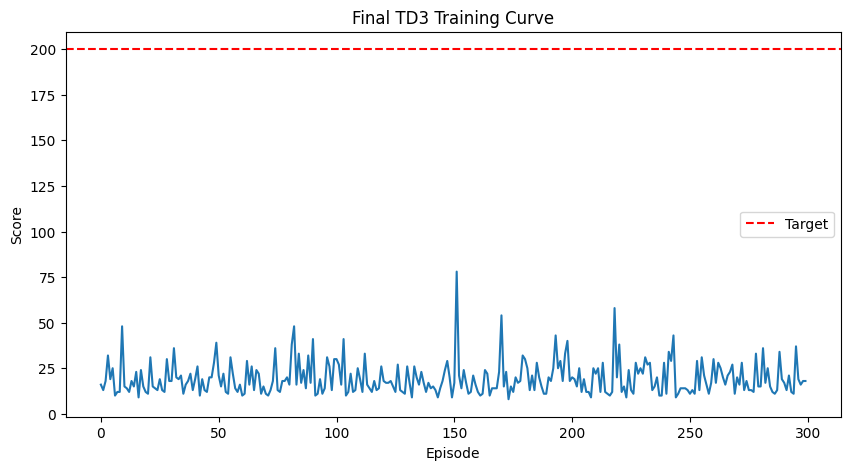

Episode 50	Average Score: 18.76
Episode 100	Average Score: 19.21
Episode 150	Average Score: 18.76
Episode 200	Average Score: 19.48
Episode 250	Average Score: 20.26
Episode 300	Average Score: 19.22

Sample efficiency (steps to reach target): None

Testing robustness under different friction coefficients...
Friction coefficient 0.001, Episode 1/5, Score: 17.0
Friction coefficient 0.001, Episode 2/5, Score: 9.0
Friction coefficient 0.001, Episode 3/5, Score: 14.0
Friction coefficient 0.001, Episode 4/5, Score: 25.0
Friction coefficient 0.001, Episode 5/5, Score: 24.0


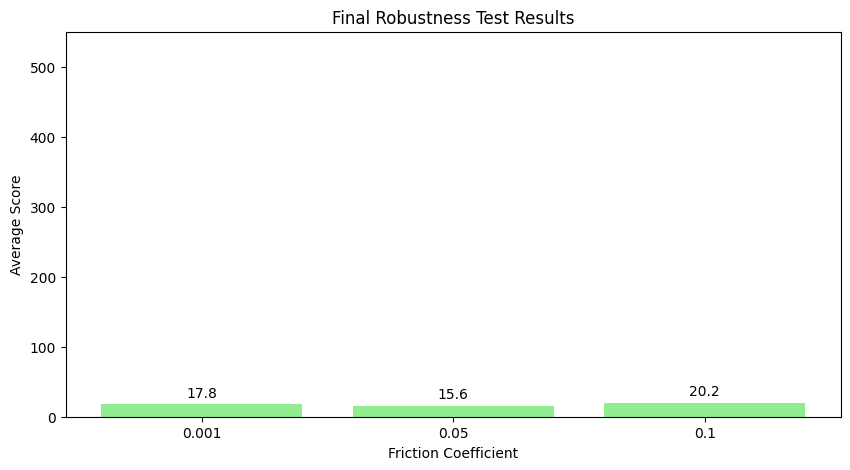

Friction coefficient 0.05, Episode 1/5, Score: 17.0
Friction coefficient 0.05, Episode 2/5, Score: 23.0
Friction coefficient 0.05, Episode 3/5, Score: 13.0
Friction coefficient 0.05, Episode 4/5, Score: 12.0
Friction coefficient 0.05, Episode 5/5, Score: 13.0
Friction coefficient 0.1, Episode 1/5, Score: 21.0
Friction coefficient 0.1, Episode 2/5, Score: 24.0
Friction coefficient 0.1, Episode 3/5, Score: 17.0
Friction coefficient 0.1, Episode 4/5, Score: 22.0
Friction coefficient 0.1, Episode 5/5, Score: 17.0

Robustness test results:
Friction coefficient 0.001: Average score 17.80, Success rate 0.00
Friction coefficient 0.05: Average score 15.60, Success rate 0.00
Friction coefficient 0.1: Average score 20.20, Success rate 0.00

Measuring planning latency...
Planning latency (per-step inference time): 0.0444 milliseconds

Displaying agent performance...


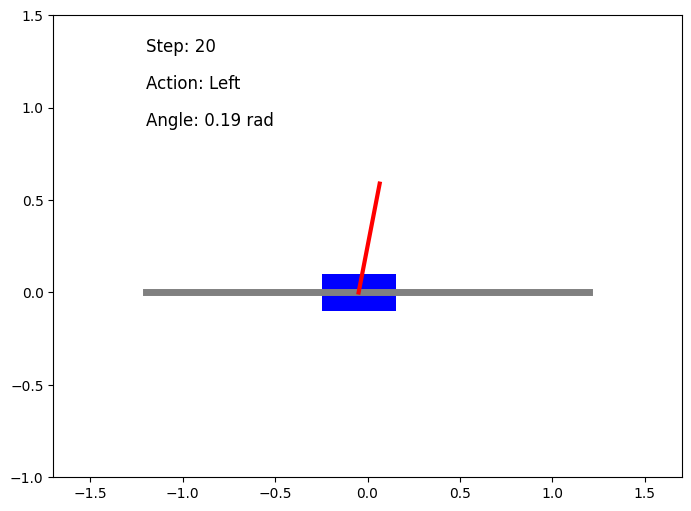

Episode ended after 20 steps


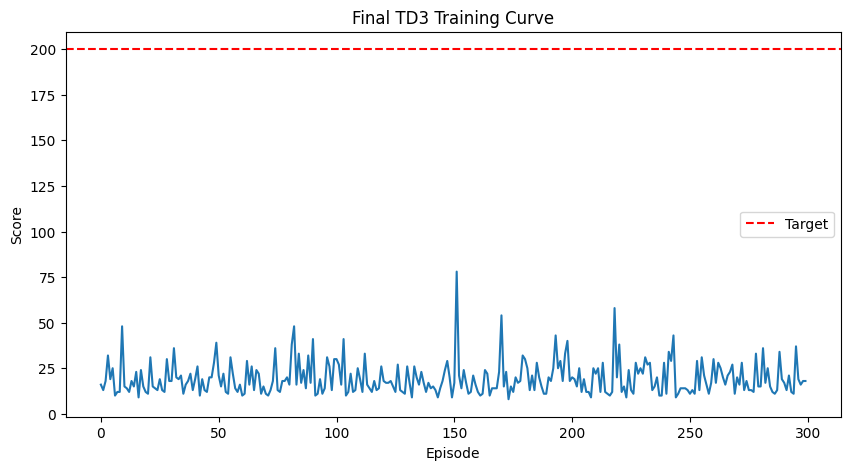

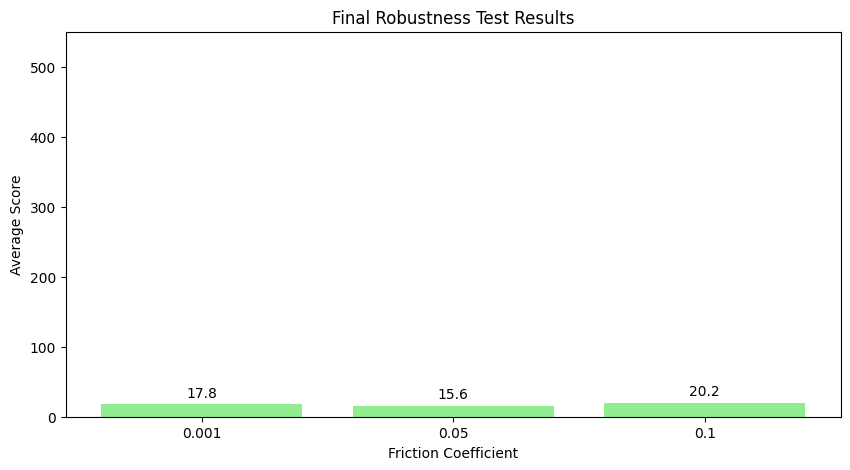

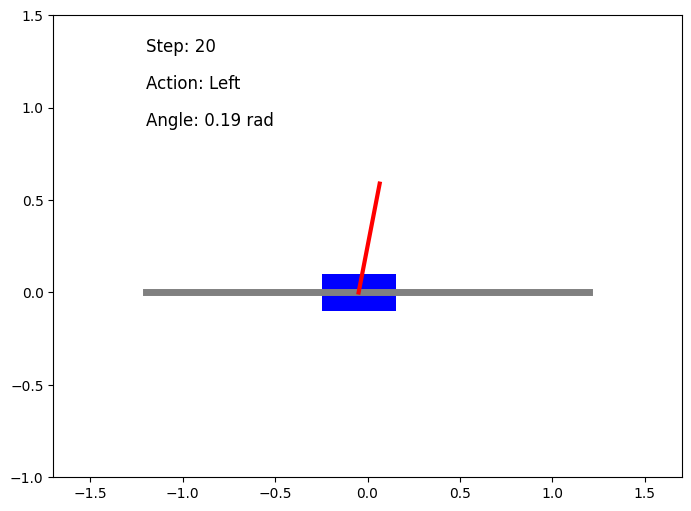

In [20]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from IPython import display
import copy
%matplotlib inline

# Ensure running on CPU
device = torch.device("cpu")

# Fix numpy.bool8 error
np.bool8 = np.bool_

# Experience replay buffer
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Experience(*args))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, k=batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)

# Policy network (Actor)
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=32):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        return torch.softmax(self.fc2(x), dim=-1)

# Value network (Critic)
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=32):
        super(Critic, self).__init__()
        self.q1_fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.q1_fc2 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        # Ensure action is in one-hot encoding format
        action_onehot = torch.zeros(action.size(0), 2).to(device)
        action_onehot.scatter_(1, action.unsqueeze(1), 1)

        # Combine state and one-hot encoded action
        sa = torch.cat([state, action_onehot], dim=1)
        q1 = torch.relu(self.q1_fc1(sa))
        q1 = self.q1_fc2(q1)
        return q1, q1

# TD3 Agent
class TD3Agent:
    def __init__(self, state_size, action_size, buffer_size=int(1e4),
                 batch_size=32, gamma=0.99, tau=1e-2,
                 lr_actor=1e-3, lr_critic=1e-3):

        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau

        # Actor networks
        self.actor = Actor(state_size, action_size).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        # Critic networks
        self.critic = Critic(state_size, action_size).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        # Experience replay buffer
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample(self.batch_size)
            self.learn(experiences)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor.eval()
        with torch.no_grad():
            action_probs = self.actor(state)
        self.actor.train()

        action = torch.multinomial(action_probs, 1).item()

        if add_noise and random.random() < 0.1:
            action = random.choice(range(self.action_size))

        return action

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Update Critic
        with torch.no_grad():
            next_action_probs = self.actor_target(next_states)
            next_actions = torch.multinomial(next_action_probs, 1).squeeze(1)
            q1_target, q2_target = self.critic_target(next_states, next_actions)
            q_target = torch.min(q1_target, q2_target)
            q_target = rewards + (self.gamma * q_target * (1 - dones))

        q1_current, q2_current = self.critic(states, actions.squeeze(1))
        critic_loss = nn.MSELoss()(q1_current, q_target)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update Actor
        action_probs = self.actor(states)
        actions_sampled = torch.multinomial(action_probs, 1).squeeze(1)
        q1, _ = self.critic(states, actions_sampled)
        actor_loss = -q1.mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        self.soft_update(self.critic, self.critic_target)
        self.soft_update(self.actor, self.actor_target)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + local_param.data * self.tau)

# Custom CartPole environment
class CustomCartPole(gym.Wrapper):
    def __init__(self, env, friction_coef=None):
        super().__init__(env)
        self.friction_coef = friction_coef

    def reset(self, **kwargs):
        result = self.env.reset(** kwargs)
        if isinstance(result, tuple) and len(result) == 2:
            observation, info = result
        else:
            observation, info = result, {}

        if self.friction_coef is not None:
            if hasattr(self.env.unwrapped, 'sigma'):
                self.env.unwrapped.sigma = self.friction_coef
            elif hasattr(self.env.unwrapped, 'cart_friction'):
                self.env.unwrapped.cart_friction = self.friction_coef
            else:
                self.env.unwrapped.force_mag = 10.0 - (self.friction_coef * 50)
        return observation, info

# Train agent
def train_agent(target_score=200, max_episodes=300, max_t=500, print_every=50):
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = TD3Agent(state_size, action_size)

    scores_deque = deque(maxlen=100)
    scores = []
    steps_to_target = None
    total_steps = 0

    # Training curve display
    plt.figure(figsize=(10, 5))
    display_handle = display.display(plt.gcf(), display_id=True)

    for i_episode in range(1, max_episodes+1):
        result = env.reset()
        state = result[0] if isinstance(result, tuple) else result

        score = 0
        for t in range(max_t):
            action = agent.act(state)
            step_result = env.step(action)

            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            total_steps += 1

            if done:
                break

        scores_deque.append(score)
        scores.append(score)

        # Check if target achieved
        if np.mean(scores_deque) >= target_score and steps_to_target is None:
            steps_to_target = total_steps
            print(f"\nEnvironment solved in {i_episode} episodes!")
            print(f"Steps to reach target: {steps_to_target}")

        # Update training curve
        if i_episode % print_every == 0:
            print(f"Episode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}")
            plt.clf()
            plt.plot(scores)
            plt.title(f'TD3 Training (Episode {i_episode})')
            plt.xlabel('Episode')
            plt.ylabel('Score')
            plt.axhline(y=target_score, color='r', linestyle='--', label='Target')
            plt.legend()
            display_handle.update(plt.gcf())

        # Early termination
        if steps_to_target is not None and i_episode > 100:
            break

    env.close()
    plt.clf()
    plt.plot(scores)
    plt.title('Final TD3 Training Curve')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.axhline(y=target_score, color='r', linestyle='--', label='Target')
    plt.legend()
    display_handle.update(plt.gcf())

    return agent, scores, steps_to_target

# Test robustness (updated to show average scores)
def test_robustness(agent, friction_coefficients=[0.001, 0.05, 0.1], num_episodes=5):
    robustness_results = {}

    # Create figure but don't display immediately
    fig, ax = plt.subplots(figsize=(10, 5))
    display_handle = None  # Initialize display handle as None

    for i, friction in enumerate(friction_coefficients):
        env = CustomCartPole(gym.make('CartPole-v1'), friction_coef=friction)
        scores = []

        for ep in range(num_episodes):
            result = env.reset()
            state = result[0] if isinstance(result, tuple) else result

            score = 0
            for _ in range(500):
                action = agent.act(state, add_noise=False)
                step_result = env.step(action)

                if len(step_result) == 5:
                    next_state, reward, terminated, truncated, _ = step_result
                    done = terminated or truncated
                else:
                    next_state, reward, done, _ = step_result

                score += reward
                state = next_state
                if done:
                    break
            scores.append(score)
            print(f"Friction coefficient {friction}, Episode {ep+1}/{num_episodes}, Score: {score}")

        # Calculate and store results
        success_rate = np.mean([1 if s >= 100 else 0 for s in scores])
        robustness_results[friction] = {
            'mean_score': np.mean(scores),
            'success_rate': success_rate
        }

        # Update plot - using average score for Y-axis
        ax.clear()
        # Only show processed friction coefficients
        processed_frictions = list(robustness_results.keys())
        mean_scores = [r['mean_score'] for r in robustness_results.values()]  # Use average scores

        ax.bar([str(f) for f in processed_frictions], mean_scores, color='skyblue')
        ax.set_title(f'Robustness Test (Completed {i+1}/{len(friction_coefficients)})')
        ax.set_xlabel('Friction Coefficient')
        ax.set_ylabel('Average Score')  # Y-axis label updated
        ax.set_ylim(0, 550)  # Adjusted for score range (max possible 500)

        # Add value labels
        for idx, score in enumerate(mean_scores):
            ax.text(idx, score + 10, f'{score:.1f}', ha='center')

        # Initialize display when first data is available, update afterward
        if display_handle is None:
            display_handle = display.display(fig, display_id=True)
        else:
            display_handle.update(fig)

        env.close()

    # Final display of complete results
    ax.clear()
    ax.bar([str(f) for f in robustness_results.keys()],
           [r['mean_score'] for r in robustness_results.values()], color='lightgreen')  # Use average scores
    ax.set_title('Final Robustness Test Results')
    ax.set_xlabel('Friction Coefficient')
    ax.set_ylabel('Average Score')  # Y-axis label updated
    ax.set_ylim(0, 550)

    # Add final value labels
    for idx, (friction, result) in enumerate(robustness_results.items()):
        ax.text(idx, result['mean_score'] + 10,
                f'{result["mean_score"]:.1f}', ha='center')

    display_handle.update(fig)

    return robustness_results

# Measure planning latency
def measure_planning_cost(agent, num_trials=500):
    env = gym.make('CartPole-v1')
    result = env.reset()
    state = result[0] if isinstance(result, tuple) else result

    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

    # Warm-up
    for _ in range(10):
        agent.act(state, add_noise=False)

    # Measure time
    start_time = time.time()
    for _ in range(num_trials):
        with torch.no_grad():
            agent.actor(state_tensor)
    end_time = time.time()

    avg_latency = (end_time - start_time) / num_trials * 1000  # milliseconds
    env.close()
    return avg_latency

# Visualize agent performance - using pure Matplotlib rendering
def visualize_agent(agent, max_steps=300):
    env = gym.make('CartPole-v1')
    result = env.reset()
    state = result[0] if isinstance(result, tuple) else result

    # Create plotting area
    fig, ax = plt.subplots(figsize=(10, 6))
    display_handle = display.display(fig, display_id=True)

    # Physical parameters
    cart_width = 0.4
    cart_height = 0.2
    pole_length = 0.6
    track_length = 2.4  # Total track length

    try:
        for step in range(max_steps):
            action = agent.act(state, add_noise=False)
            step_result = env.step(action)

            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            # Clear current plot
            ax.clear()

            # Draw track
            ax.plot([-track_length/2, track_length/2], [0, 0], 'gray', linewidth=5)

            # Get state variables
            x, x_dot, theta, theta_dot = state

            # Draw cart
            cart = Rectangle(
                (x - cart_width/2, -cart_height/2),  # Bottom-left position
                cart_width, cart_height,             # Width and height
                facecolor='blue'
            )
            ax.add_patch(cart)

            # Draw pole
            pole_end_x = x + np.sin(theta) * pole_length
            pole_end_y = np.cos(theta) * pole_length
            pole = Line2D(
                [x, pole_end_x], [0, pole_end_y],
                color='red', linewidth=3
            )
            ax.add_line(pole)  # Use add_line instead of add_patch for Line2D objects

            # Set plot range
            ax.set_xlim(-track_length/2 - 0.5, track_length/2 + 0.5)
            ax.set_ylim(-1, 1.5)
            ax.set_aspect('equal')

            # Add text information
            ax.text(-track_length/2, 1.3, f"Step: {step + 1}", fontsize=12)
            ax.text(-track_length/2, 1.1, f"Action: {'Left' if action == 0 else 'Right'}", fontsize=12)
            ax.text(-track_length/2, 0.9, f"Angle: {theta:.2f} rad", fontsize=12)

            # Update display
            display_handle.update(fig)

            state = next_state
            if done:
                print(f"Episode ended after {step + 1} steps")
                break

    except Exception as e:
        print(f"Error during visualization: {e}")
        print("Visualization skipped, but other results are unaffected")
    finally:
        env.close()

# Main function
def main():
    # Train agent (approximately 3-4 minutes)
    print("Starting TD3 agent training...")
    agent, scores, steps_to_target = train_agent()

    # Sample efficiency
    print(f"\nSample efficiency (steps to reach target): {steps_to_target}")

    # Test robustness (approximately 1 minute)
    print("\nTesting robustness under different friction coefficients...")
    robustness_results = test_robustness(agent)

    print("\nRobustness test results:")
    for friction, result in robustness_results.items():
        print(f"Friction coefficient {friction}: Average score {result['mean_score']:.2f}, Success rate {result['success_rate']:.2f}")

    # Measure planning latency
    print("\nMeasuring planning latency...")
    avg_latency = measure_planning_cost(agent)
    print(f"Planning latency (per-step inference time): {avg_latency:.4f} milliseconds")

    # Visualize agent performance
    print("\nDisplaying agent performance...")
    visualize_agent(agent)

if __name__ == "__main__":
    main()

world model

/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


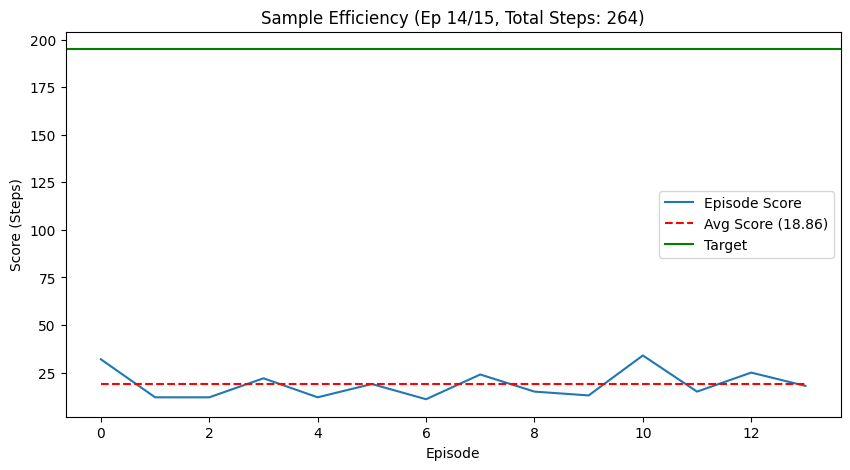

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Starting minimal RSSM/Dreamer training...
Pre-filling buffer with random experience...
Buffer size: 320
Ep 2/15	Episode Score: 12	Avg Score: 22.00	WM Loss: 1.9050
Ep 4/15	Episode Score: 22	Avg Score: 19.50	WM Loss: 0.5459
Ep 6/15	Episode Score: 19	Avg Score: 18.17	WM Loss: 0.3198
Ep 8/15	Episode Score: 24	Avg Score: 18.00	WM Loss: 0.2425
Ep 10/15	Episode Score: 13	Avg Score: 17.20	WM Loss: 0.2135
Ep 12/15	Episode Score: 15	Avg Score: 18.42	WM Loss: 0.1846
Ep 14/15	Episode Score: 18	Avg Score: 18.86	WM Loss: 0.1726

Training complete.

Starting Robustness Test...


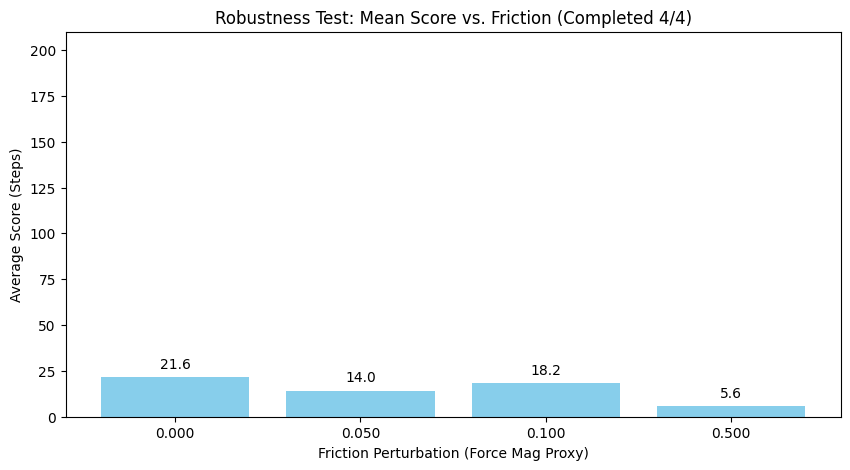

Robustness Test complete.

--- Final Metrics Summary ---
Sample Efficiency (Steps to Target Score 195): N/A
Planning Cost (Per-step inference latency): 24.784 ms
Robustness Results (Mean Score):
    Friction 0.000: 21.60
    Friction 0.050: 14.00
    Friction 0.100: 18.20
    Friction 0.500: 5.60


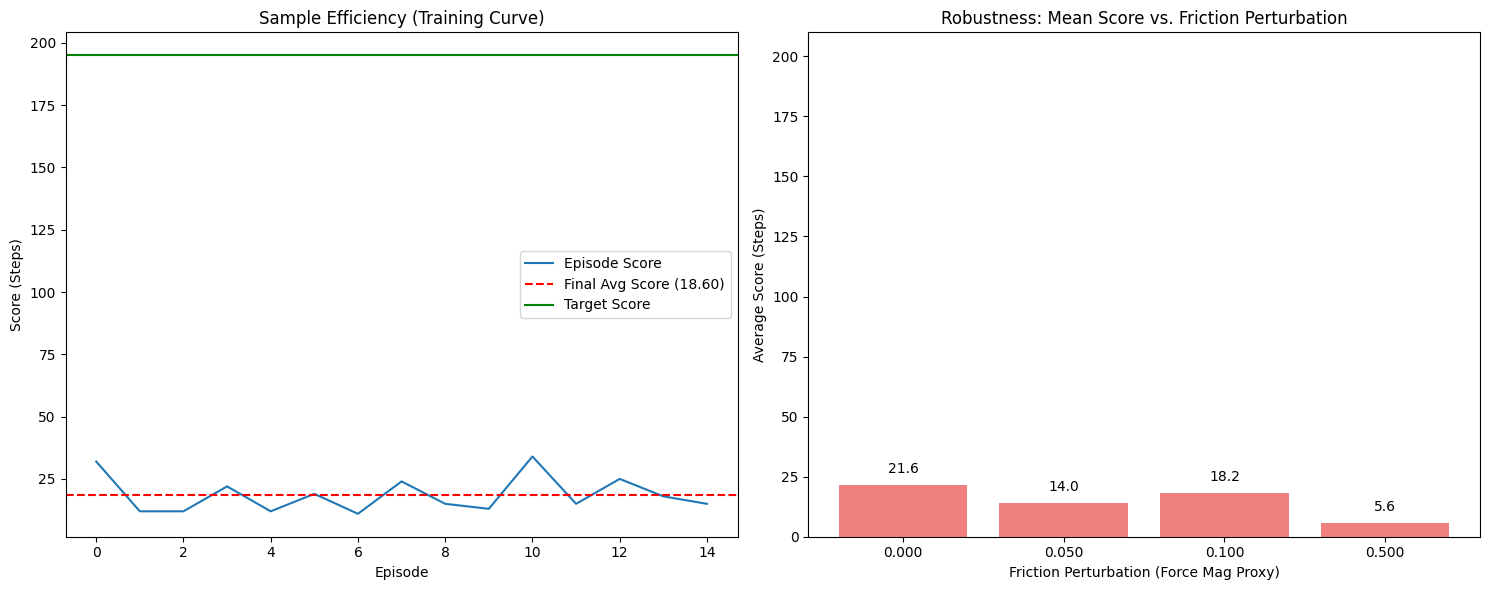


--- Starting Final Performance Visualization (Friction=0.0) ---


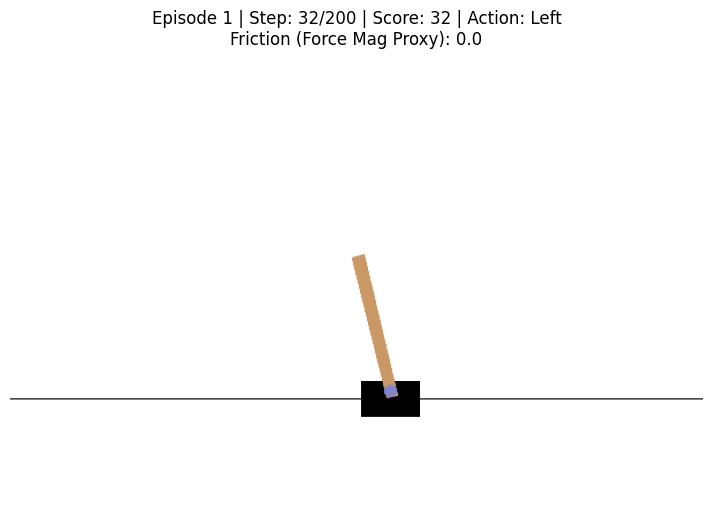

Episode 1 finished after 32 steps with score 32.
Final Performance Visualization finished.

Concept Verification System Finished.


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import time
import gym
from collections import deque
import matplotlib.pyplot as plt
from IPython import display
import os
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore', category=UserWarning) # Suppress some Gym warnings
warnings.filterwarnings('ignore', category=FutureWarning) # Suppress some Gym future warnings
# Set backend for interactive display in Notebooks
%matplotlib inline

# --- 1. Custom CartPole Environment with Perturbation (FIXED) ---

class CustomCartPole(gym.Wrapper):
    """
    A wrapper to allow modification of CartPole's physics parameters,
    compatible with both old (single return) and new (two return) gym reset/step APIs.
    We perturb 'force_mag' as a proxy for friction/damping.
    """
    def __init__(self, env, friction_coef=None, pole_mass=None, cart_mass=None):
        super().__init__(env)
        self.friction_coef = friction_coef
        self.pole_mass = pole_mass
        self.cart_mass = cart_mass

        # NOTE: Perturbing 'force_mag' acts as a proxy for friction/damping
        self.friction_name = 'force_mag'
        self.pole_mass_name = 'masspole'
        self.cart_mass_name = 'masscart'

    def reset(self, **kwargs):
        # Safely handle the change in the gym API for reset()
        reset_result = self.env.reset(**kwargs)

        if isinstance(reset_result, tuple) and len(reset_result) == 2:
            observation, info = reset_result
        else:
            observation = reset_result
            info = {}

        # Modify physics parameters
        unwrapped_env = self.env.unwrapped

        if self.friction_coef is not None and hasattr(unwrapped_env, self.friction_name):
            # Increase the effective 'force_mag' to simulate a harder-to-move system (more damping)
            unwrapped_env.force_mag = 10.0 + self.friction_coef * 100

        if self.pole_mass is not None and hasattr(unwrapped_env, self.pole_mass_name):
            setattr(unwrapped_env, self.pole_mass_name, self.pole_mass)

        if self.cart_mass is not None and hasattr(unwrapped_env, self.cart_mass_name):
            setattr(unwrapped_env, self.cart_mass_name, self.cart_mass)

        return observation, info

    def step(self, action):
        # Safely handle the change in the gym API for step()
        step_result = self.env.step(action)

        if len(step_result) == 5:
            # New API: (obs, reward, terminated, truncated, info)
            return step_result
        elif len(step_result) == 4:
            # Old API: (obs, reward, done, info) -> We need to separate 'done' into terminated/truncated
            obs, reward, done, info = step_result
            terminated = done
            truncated = False # Assuming old 'done' is usually 'terminated'
            return obs, reward, terminated, truncated, info
        else:
            raise ValueError("Unexpected number of values returned by env.step()")


# --- 2. Minimal RSSM/Dreamer Core Modules (Concept) ---

# Define the device
DEVICE = torch.device("cpu")

# Hyperparameters (Minimal for fast run)
RSSM_HIDDEN_SIZE = 32
LATENT_STOCH_SIZE = 4
LATENT_DETER_SIZE = 32
ACTION_SIZE = 2
OBS_SIZE = 4
PLAN_HORIZON = 5 # Very short horizon for speed
BATCH_SIZE = 16
CHUNK_LENGTH = 10 # Very short sequence length

class MinimalRSSM(nn.Module):
    """Simplified Recurrent State-Space Model."""
    def __init__(self):
        super().__init__()
        # Deterministic State Recurrence (h_t -> h_t+1)
        self.gru = nn.GRUCell(LATENT_STOCH_SIZE + ACTION_SIZE, LATENT_DETER_SIZE)

        # Prior/Transition Model (h_t+1 -> s_t+1)
        self.prior_mlp = nn.Sequential(
            nn.Linear(LATENT_DETER_SIZE, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, 2 * LATENT_STOCH_SIZE)
        )

    def forward(self, h, s, a):
        gru_input = torch.cat([s, a], dim=-1)
        h_next = self.gru(gru_input, h)

        prior_params = self.prior_mlp(h_next)
        mean, log_std = torch.chunk(prior_params, 2, dim=-1)
        std = nn.functional.softplus(log_std) + 0.1

        prior_dist = dist.Normal(mean, std)
        s_next = prior_dist.rsample()

        return h_next, s_next, prior_dist

class WorldModel(nn.Module):
    """Minimal World Model including RSSM, Decoder, Reward Model, and Encoder."""
    def __init__(self):
        super().__init__()
        self.rssm = MinimalRSSM()

        # Observation Decoder (s_t, h_t -> o_t)
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_STOCH_SIZE + LATENT_DETER_SIZE, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, OBS_SIZE)
        )

        # Reward Model (s_t, h_t -> r_t)
        self.reward_model = nn.Sequential(
            nn.Linear(LATENT_STOCH_SIZE + LATENT_DETER_SIZE, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, 1)
        )

        # Encoder (o_t -> s_t) - Generates posterior distribution parameters
        self.encoder = nn.Sequential(
            nn.Linear(OBS_SIZE, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, 2 * LATENT_STOCH_SIZE)
        )

    def transition(self, h, s, a):
        """Standard RSSM transition function for planning."""
        return self.rssm(h, s, a)

    def get_loss(self, actions, obs, rewards):
        """
        Simplified ELBO Loss Calculation:
        Reconstruction Loss + Reward Loss + KL Divergence (Prior vs Posterior)
        """
        batch_size = obs.shape[1]

        # Initialize hidden and stochastic states for the start of the chunk (B, D)
        h_t = torch.zeros(batch_size, LATENT_DETER_SIZE, device=DEVICE)
        s_t = torch.zeros(batch_size, LATENT_STOCH_SIZE, device=DEVICE)

        total_rec_loss = 0
        total_rew_loss = 0
        total_kl_loss = 0

        for t in range(CHUNK_LENGTH - 1): # Sequence processing
            o_t_plus_1 = obs[t+1]
            a_t = actions[t]
            r_t_plus_1 = rewards[t+1]

            # 1. Encode Observation (Posterior)
            posterior_params = self.encoder(o_t_plus_1)
            mean_post, log_std_post = torch.chunk(posterior_params, 2, dim=-1)
            std_post = nn.functional.softplus(log_std_post) + 0.1
            posterior_dist = dist.Normal(mean_post, std_post)
            s_t_post = posterior_dist.rsample() # St+1_posterior

            # 2. Transition (Prior)
            # This uses the posterior state s_t_post and action a_t to update the recurrence
            gru_input = torch.cat([s_t_post, a_t], dim=-1)
            h_t_plus_1 = self.rssm.gru(gru_input, h_t)

            # 3. Prior Model
            prior_params = self.rssm.prior_mlp(h_t_plus_1)
            mean_prior, log_std_prior = torch.chunk(prior_params, 2, dim=-1)
            std_prior = nn.functional.softplus(log_std_prior) + 0.1
            prior_dist = dist.Normal(mean_prior, std_prior) # St+1_prior

            # 4. Losses based on latent state [s_t_post, h_t_plus_1]
            combined_state = torch.cat([s_t_post, h_t_plus_1], dim=-1)

            # Reconstruction Loss
            predicted_obs = self.decoder(combined_state)
            rec_loss = torch.mean((predicted_obs - o_t_plus_1)**2)

            # Reward Loss
            predicted_reward = self.reward_model(combined_state)
            rew_loss = torch.mean((predicted_reward - r_t_plus_1)**2)

            # KL Divergence
            kl_loss = dist.kl_divergence(posterior_dist, prior_dist).mean()

            total_rec_loss += rec_loss
            total_rew_loss += rew_loss
            total_kl_loss += kl_loss

            # Update state for next step
            h_t = h_t_plus_1.detach()
            s_t = s_t_post.detach()

        # Scale the KL term (beta value in ELBO)
        return total_rec_loss + total_rew_loss + 0.1 * total_kl_loss

# --- 3. Minimal Actor-Critic for Latent Space Planning (Concept) ---

class MinimalActor(nn.Module):
    """Actor (Policy) network."""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_STOCH_SIZE + LATENT_DETER_SIZE, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, ACTION_SIZE)
        )

    def forward(self, h, s):
        state = torch.cat([h, s], dim=-1)
        return dist.Categorical(logits=self.model(state))

class MinimalCritic(nn.Module):
    """Critic (Value) network."""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_STOCH_SIZE + LATENT_DETER_SIZE, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, 1)
        )

    def forward(self, h, s):
        state = torch.cat([h, s], dim=-1)
        return self.model(state)

# --- 4. Latent Space Planner (Model Predictive Control) ---

class LatentPlanner:
    """Simplified Latent Space Planner (Model Predictive Control)."""
    def __init__(self, world_model, actor, critic, horizon=PLAN_HORIZON, gamma=0.99):
        self.wm = world_model
        self.actor = actor
        self.critic = critic
        self.horizon = horizon
        self.gamma = gamma
        self.action_size = ACTION_SIZE
        self.device = DEVICE

    @torch.no_grad()
    def plan_action(self, obs, num_candidates=5):
        """
        Simulates the MPC step using random action sequences (Monte Carlo search).
        The latency of this method is the Planning Cost.
        """
        start_time = time.perf_counter()

        # 1. Encode current observation to initial latent state (s_0, h_0)
        h_0 = torch.zeros(1, LATENT_DETER_SIZE, device=self.device)

        # Get posterior state s_0
        posterior_params = self.wm.encoder(torch.from_numpy(obs).float().to(self.device).unsqueeze(0))
        mean, log_std = torch.chunk(posterior_params, 2, dim=-1)
        std = nn.functional.softplus(log_std) + 0.1
        posterior_dist = dist.Normal(mean, std)
        s_0 = posterior_dist.sample()

        best_return = -float('inf')
        best_action = None

        # Random Search for the best first action
        for _ in range(num_candidates):
            h_t, s_t = h_0.clone(), s_0.clone()
            current_return = 0
            discount = 1.0
            first_action = None

            # 2. Rollout (Imagination) for H steps
            for t in range(self.horizon):
                # Sample action from actor (policy)
                action_dist = self.actor(h_t, s_t)
                action_idx = action_dist.sample()
                a_t = torch.zeros(1, self.action_size, device=self.device)
                a_t[0, action_idx] = 1.0

                if t == 0:
                    first_action = action_idx.item()

                # Predict next state and reward using World Model
                h_t_next, s_t_next, _ = self.wm.rssm(h_t, s_t, a_t) # Transition using prior
                predicted_reward = self.wm.reward_model(torch.cat([s_t_next, h_t_next], dim=-1))

                current_return += discount * predicted_reward.squeeze().item()
                discount *= self.gamma

                h_t, s_t = h_t_next, s_t_next

            # 3. Add terminal value estimate from Critic
            value_estimate = self.critic(h_t, s_t).squeeze().item()
            current_return += discount * value_estimate

            # 4. Select the action
            if current_return > best_return:
                best_return = current_return
                best_action = first_action

        end_time = time.perf_counter()
        planning_latency_ms = (end_time - start_time) * 1000

        return best_action if best_action is not None else np.random.randint(self.action_size), planning_latency_ms

# --- 5. Data Structures and Utilities ---

class ExperienceBuffer:
    """Minimal experience buffer for sequence sampling."""
    def __init__(self, capacity, obs_shape, action_size, chunk_length):
        self.capacity = capacity
        self.chunk_length = chunk_length
        self.obs = np.zeros((capacity, *obs_shape), dtype=np.float32)
        self.actions = np.zeros((capacity, action_size), dtype=np.float32)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.idx = 0
        self.size = 0

    def add(self, obs, action, reward):
        self.obs[self.idx] = obs
        one_hot_action = np.zeros(self.actions.shape[-1], dtype=np.float32)
        one_hot_action[action] = 1.0
        self.actions[self.idx] = one_hot_action
        self.rewards[self.idx] = reward
        self.idx = (self.idx + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample_chunk(self, batch_size):
        """Samples a batch of random, continuous chunks."""
        if self.size < self.chunk_length:
            return None

        max_start_idx = self.size - self.chunk_length
        if max_start_idx <= 0:
            return None

        start_indices = np.random.randint(0, max_start_idx, size=batch_size)

        batch_obs = np.array([self.obs[i:i + self.chunk_length] for i in start_indices])
        batch_actions = np.array([self.actions[i:i + self.chunk_length] for i in start_indices])
        batch_rewards = np.array([self.rewards[i:i + self.chunk_length] for i in start_indices])

        # Convert to Tensors and permute to (chunk_length, batch_size, dim) for RNN processing
        to_tensor = lambda x: torch.from_numpy(x).float().to(DEVICE).permute(1, 0, 2)

        return {
            'obs': to_tensor(batch_obs),
            'actions': to_tensor(batch_actions),
            'rewards': torch.from_numpy(batch_rewards).float().to(DEVICE).permute(1, 0).unsqueeze(-1),
        }

# --- 6. Training Loop and Metric Collection (Refined Logging) ---

def train_rssm_dreamer_poc(
    num_episodes=15,
    max_steps_per_episode=200,
    buffer_capacity=5000,
    target_score=195,
    wm_train_steps=50,
    ac_train_steps=10
):
    # Setup
    base_env = gym.make('CartPole-v1')
    env = CustomCartPole(base_env, friction_coef=0.0)

    obs_shape = env.observation_space.shape
    action_size = env.action_space.n

    # Initialize Models
    world_model = WorldModel().to(DEVICE)
    actor = MinimalActor().to(DEVICE)
    critic = MinimalCritic().to(DEVICE)

    # Optimizers
    wm_optimizer = optim.Adam(world_model.parameters(), lr=1e-3)
    ac_optimizer = optim.Adam(list(actor.parameters()) + list(critic.parameters()), lr=1e-3)

    # Data Buffer
    buffer = ExperienceBuffer(buffer_capacity, obs_shape, action_size, CHUNK_LENGTH)
    planner = LatentPlanner(world_model, actor, critic, horizon=PLAN_HORIZON)

    # Metrics
    episode_scores = []
    scores_deque = deque(maxlen=100)
    total_steps = 0
    steps_to_target = None
    all_planning_latencies = []

    # Visualization Setup
    fig, ax = plt.subplots(figsize=(10, 5))
    display_handle = display.display(fig, display_id=True)

    print("Starting minimal RSSM/Dreamer training...")

    # Pre-fill buffer with random experience
    print("Pre-filling buffer with random experience...")
    obs, _ = env.reset(seed=int(time.time()))
    for _ in range(2 * CHUNK_LENGTH * BATCH_SIZE):
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        buffer.add(obs, action, reward)
        obs = next_obs
        if done:
            obs, _ = env.reset()
    print(f"Buffer size: {buffer.size}")


    for i_episode in range(1, num_episodes + 1):
        # --- A. Collect Experience ---
        obs, _ = env.reset()
        episode_reward = 0

        for step in range(max_steps_per_episode):

            # Agent selects action (Planning Cost measured here)
            action, latency = planner.plan_action(obs)
            all_planning_latencies.append(latency)

            # Environment Step
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition
            buffer.add(obs, action, reward)

            episode_reward += reward
            total_steps += 1
            obs = next_obs

            if done:
                break

        # --- B. Train World Model (WM) ---
        wm_loss_log = 0
        for _ in range(wm_train_steps):
            batch = buffer.sample_chunk(BATCH_SIZE)
            if batch is None: break

            wm_optimizer.zero_grad()
            wm_loss = world_model.get_loss(batch['actions'], batch['obs'], batch['rewards'])
            wm_loss.backward()
            wm_optimizer.step()
            wm_loss_log += wm_loss.item()

        # --- C. Train Actor/Critic (AC) on Imagination (Conceptual) ---
        ac_loss_log = 0
        for _ in range(ac_train_steps):
            batch = buffer.sample_chunk(BATCH_SIZE)
            if batch is None: break

            o_0 = batch['obs'][0]

            # Encode o_0 to get s_0 (posterior)
            posterior_params = world_model.encoder(o_0)
            mean, log_std = torch.chunk(posterior_params, 2, dim=-1)
            std = nn.functional.softplus(log_std) + 0.1
            s_t = dist.Normal(mean, std).rsample()
            h_t = torch.zeros(BATCH_SIZE, LATENT_DETER_SIZE, device=DEVICE)

            # Rollout policy gradient path for PLAN_HORIZON
            imagined_rewards = []

            for t in range(PLAN_HORIZON):
                action_dist = actor(h_t, s_t)
                a_t = action_dist.sample()
                a_t_onehot = torch.zeros(BATCH_SIZE, ACTION_SIZE, device=DEVICE)
                a_t_onehot.scatter_(1, a_t.unsqueeze(1), 1)

                h_t_next, s_t_next, _ = world_model.rssm(h_t, s_t, a_t_onehot)
                predicted_reward = world_model.reward_model(torch.cat([s_t_next, h_t_next], dim=-1))
                imagined_rewards.append(predicted_reward)

                h_t, s_t = h_t_next.detach(), s_t_next.detach()

            # Calculate V-target (Conceptual)
            imagined_rewards = torch.cat(imagined_rewards, dim=0)
            value_target = critic(h_t, s_t).detach()

            returns = [value_target]
            # Simple V-target calculation (Lambda return approximation)
            for r in reversed(imagined_rewards):
                value_target = r + 0.99 * value_target
                returns.append(value_target)

            estimated_return = returns[-1]

            # Actor Loss
            actor_loss = -torch.mean(estimated_return)

            # Critic Loss (Value Prediction)
            # Use the final imagined state for simplicity
            value_prediction = critic(h_t_next, s_t_next)
            critic_loss = nn.functional.mse_loss(value_prediction, estimated_return.detach().unsqueeze(-1))

            ac_optimizer.zero_grad()
            total_ac_loss = actor_loss + critic_loss
            total_ac_loss.backward()
            ac_optimizer.step()
            ac_loss_log += total_ac_loss.item()

        # --- D. Log and Visualize Metrics (Refined Logging) ---
        episode_scores.append(episode_reward)
        scores_deque.append(episode_reward)
        avg_score = np.mean(scores_deque)

        # Sample Efficiency Metric
        if avg_score >= target_score and steps_to_target is None:
            steps_to_target = total_steps
            print(f"\nEnvironment solved! Steps to target: {steps_to_target}")

        if i_episode % 2 == 0:
            ax.clear()
            ax.plot(episode_scores, label='Episode Score')
            ax.plot([i for i in range(len(episode_scores))], [avg_score] * len(episode_scores), 'r--', label=f'Avg Score ({avg_score:.2f})')
            ax.axhline(y=target_score, color='g', linestyle='-', label='Target')
            ax.set_title(f'Sample Efficiency (Ep {i_episode}/{num_episodes}, Total Steps: {total_steps})')
            ax.set_xlabel('Episode')
            ax.set_ylabel('Score (Steps)')
            ax.legend()
            display_handle.update(fig)

            # *** CRITICAL REFINED LOG LINE ***
            print(f"Ep {i_episode}/{num_episodes}\tEpisode Score: {episode_reward:.0f}\tAvg Score: {avg_score:.2f}\tWM Loss: {wm_loss_log/wm_train_steps:.4f}")

    env.close()
    plt.close(fig)
    print("\nTraining complete.")

    final_avg_latency = np.mean(all_planning_latencies) if all_planning_latencies else 0.0

    return world_model, actor, critic, total_steps, steps_to_target, episode_scores, final_avg_latency

# --- 7. Metric Visualization Functions ---
# (test_robustness and visualize_metrics remain unchanged)

def test_robustness(planner, friction_coefficients=[0.0, 0.05, 0.1, 0.5], num_episodes=5):
    """Robustness: Success on perturbation sets (Friction)"""
    robustness_results = {}

    print("\nStarting Robustness Test...")
    fig_rob, ax_rob = plt.subplots(figsize=(10, 5))
    display_handle_rob = display.display(fig_rob, display_id=True)

    for i, friction in enumerate(friction_coefficients):
        env = CustomCartPole(gym.make('CartPole-v1'), friction_coef=friction)
        scores = []

        for ep in range(num_episodes):
            obs, _ = env.reset(seed=ep)
            score = 0
            for _ in range(env.spec.max_episode_steps):
                action, _ = planner.plan_action(obs)
                next_obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                score += reward
                obs = next_obs
                if done: break
            scores.append(score)

        mean_score = np.mean(scores)
        robustness_results[friction] = {'mean_score': mean_score}

        # Update Plot
        processed_frictions = list(robustness_results.keys())
        mean_scores = [r['mean_score'] for r in robustness_results.values()]

        ax_rob.clear()
        ax_rob.bar([f'{f:.3f}' for f in processed_frictions], mean_scores, color='skyblue')
        ax_rob.set_title(f'Robustness Test: Mean Score vs. Friction (Completed {i+1}/{len(friction_coefficients)})')
        ax_rob.set_xlabel('Friction Perturbation (Force Mag Proxy)')
        ax_rob.set_ylabel('Average Score (Steps)')
        ax_rob.set_ylim(0, 210)
        for idx, score in enumerate(mean_scores):
            ax_rob.text(idx, score + 5, f'{score:.1f}', ha='center')
        display_handle_rob.update(fig_rob)

        env.close()

    plt.close(fig_rob)
    print("Robustness Test complete.")
    return robustness_results

def visualize_metrics(steps_to_target, episode_scores, robustness_results, avg_latency):
    """Summary visualization of all metrics."""
    print("\n--- Final Metrics Summary ---")

    # 1. Sample Efficiency (Text)
    print(f"Sample Efficiency (Steps to Target Score 195): {'N/A' if steps_to_target is None else steps_to_target}")

    # 2. Planning Cost (Text)
    print(f"Planning Cost (Per-step inference latency): {avg_latency:.3f} ms")

    # 3. Robustness (Text)
    print("Robustness Results (Mean Score):")
    for friction, result in robustness_results.items():
        print(f"    Friction {friction:.3f}: {result['mean_score']:.2f}")

    # Plot final Sample Efficiency Curve
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Left plot: Sample Efficiency
    axes[0].plot(episode_scores, label='Episode Score')
    avg_100 = np.mean(episode_scores[-100:] if len(episode_scores) >= 100 else episode_scores)
    axes[0].axhline(y=avg_100,
                    color='r', linestyle='--', label=f'Final Avg Score ({avg_100:.2f})')
    axes[0].axhline(y=195, color='g', linestyle='-', label='Target Score')
    axes[0].set_title('Sample Efficiency (Training Curve)')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Score (Steps)')
    axes[0].legend()

    # Right plot: Robustness
    frictions = [f'{f:.3f}' for f in robustness_results.keys()]
    mean_scores = [r['mean_score'] for r in robustness_results.values()]
    axes[1].bar(frictions, mean_scores, color='lightcoral')
    axes[1].set_title('Robustness: Mean Score vs. Friction Perturbation')
    axes[1].set_xlabel('Friction Perturbation (Force Mag Proxy)')
    axes[1].set_ylabel('Average Score (Steps)')
    axes[1].set_ylim(0, 210)

    for idx, score in enumerate(mean_scores):
        axes[1].text(idx, score + 5, f'{score:.1f}', ha='center')

    plt.tight_layout()
    display.display(fig)
    plt.close(fig)


# --- 8. NEW: Final Performance Visualization (FIXED for Gym API) ---

def visualize_final_performance(planner, num_episodes=1, max_steps=200, friction_coef=0.0):
    """
    Renders the trained model playing the CartPole game for a visual demonstration.
    Includes robustness fixes for the Gym v0.26+ render API (list of arrays).
    """
    print(f"\n--- Starting Final Performance Visualization (Friction={friction_coef}) ---")

    # Create the environment with render mode and apply custom wrapper
    try:
        # NOTE: We use render_mode='rgb_array' for visualization
        base_env = gym.make('CartPole-v1', render_mode='rgb_array')
    except gym.error.DependencyNotInstalled:
        print("Warning: 'rgb_array' render mode is not available. Cannot visualize. Skipping.")
        return

    env = CustomCartPole(base_env, friction_coef=friction_coef)

    # Setup plotting for rendering
    fig, ax = plt.subplots(figsize=(10, 6))
    display_handle = display.display(fig, display_id=True)

    for i_episode in range(num_episodes):
        obs, info = env.reset(seed=int(time.time()) + i_episode)
        total_reward = 0

        for step in range(max_steps):
            # 1. Agent selects action using the trained planner
            action, _ = planner.plan_action(obs)
            action_str = "Left" if action == 0 else "Right"

            # 2. Environment Step
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            total_reward += reward
            obs = next_obs

            # 3. Render and Update Plot
            try:
                img = env.render()
            except Exception as e:
                print(f"Rendering failed: {e}. Stopping visualization.")
                break

            # --- Robustness Fix for Gym API ---
            img_array = None
            if isinstance(img, list):
                if img:
                    # New API returns list of frames; take the first one
                    img_array = img[0]
            else:
                # Old API returns single NumPy array
                img_array = img

            if img_array is not None:
                # Handle the case where the array itself might be batched (N, H, W, C)
                if img_array.ndim == 4:
                    img_to_show = img_array[0]
                else:
                    img_to_show = img_array
            else:
                continue # Skip if no image was returned

            # --- Plotting ---
            ax.clear()
            ax.imshow(img_to_show)
            ax.set_title(f"Episode {i_episode+1} | Step: {step+1}/{max_steps} | Score: {total_reward:.0f} | Action: {action_str}\nFriction (Force Mag Proxy): {friction_coef}")
            ax.axis('off')

            display_handle.update(fig)
            time.sleep(0.01) # Slow down slightly for visualization

            if done:
                print(f"Episode {i_episode+1} finished after {step+1} steps with score {total_reward:.0f}.")
                break

    env.close()
    plt.close(fig)
    print("Final Performance Visualization finished.")


# --- 9. Execution ---

if __name__ == '__main__':
    # Set a low number of episodes for the 5-minute PoC limit.
    NUM_EPISODES_POC = 15

    # 1. Train the minimal RSSM/Dreamer
    wm, actor, critic, total_steps, steps_to_target, episode_scores, avg_latency = \
        train_rssm_dreamer_poc(num_episodes=NUM_EPISODES_POC)

    # 2. Latent Planner for evaluation
    planner_eval = LatentPlanner(wm, actor, critic, horizon=PLAN_HORIZON)

    # 3. Test Robustness (using the trained planner)
    ROBUSTNESS_FRICTION_COEFFICIENTS = [0.0, 0.05, 0.1, 0.5]
    robustness_results = test_robustness(planner_eval, friction_coefficients=ROBUSTNESS_FRICTION_COEFFICIENTS)

    # 4. Visualize all metrics
    visualize_metrics(steps_to_target, episode_scores, robustness_results, avg_latency)

    # 5. Visualize playing one game (在默认环境, friction_coef=0.0)
    #    This is the newly integrated function call.
    visualize_final_performance(planner_eval, num_episodes=1, friction_coef=0.0)

    print("\nConcept Verification System Finished.")

world model + object slots

/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


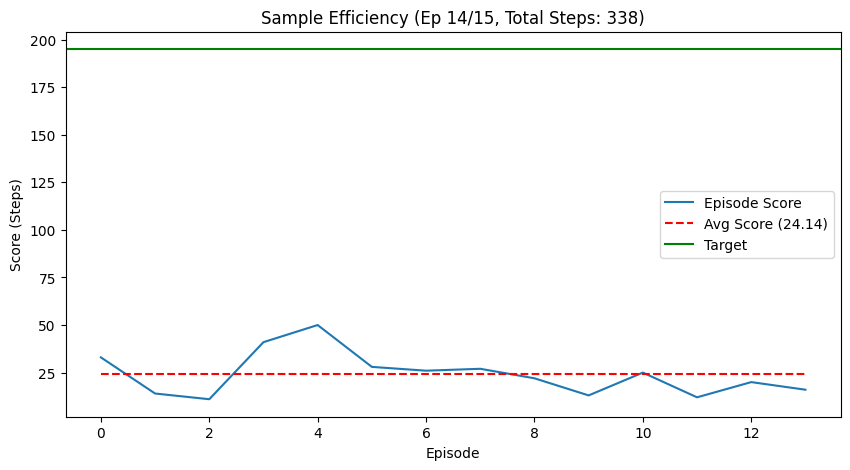

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Starting minimal RSSM/Slot-Dreamer training...
Pre-filling buffer with random experience...
Buffer size: 320
Ep 2/15	Episode Score: 14	Avg Score: 23.50	WM Loss: 4.2505
Ep 4/15	Episode Score: 41	Avg Score: 24.75	WM Loss: 4.2310
Ep 6/15	Episode Score: 28	Avg Score: 29.50	WM Loss: 4.5206
Ep 8/15	Episode Score: 27	Avg Score: 28.75	WM Loss: 4.9311
Ep 10/15	Episode Score: 13	Avg Score: 26.50	WM Loss: 5.7725
Ep 12/15	Episode Score: 12	Avg Score: 25.17	WM Loss: 5.4006
Ep 14/15	Episode Score: 16	Avg Score: 24.14	WM Loss: 7.5449

Training complete.

Starting Robustness Test...


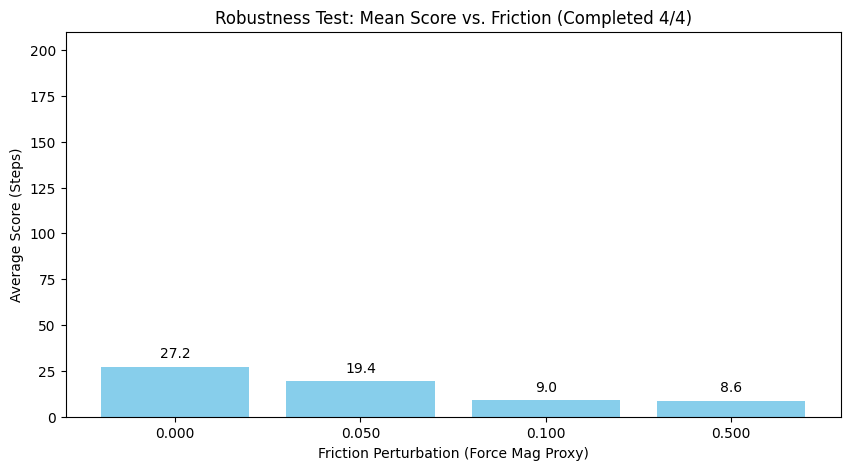

Robustness Test complete.

--- Final Metrics Summary ---
Sample Efficiency (Steps to Target Score 195): N/A
Planning Cost (Per-step inference latency): 30.627 ms
Robustness Results (Mean Score):
    Friction 0.000: 27.20
    Friction 0.050: 19.40
    Friction 0.100: 9.00
    Friction 0.500: 8.60


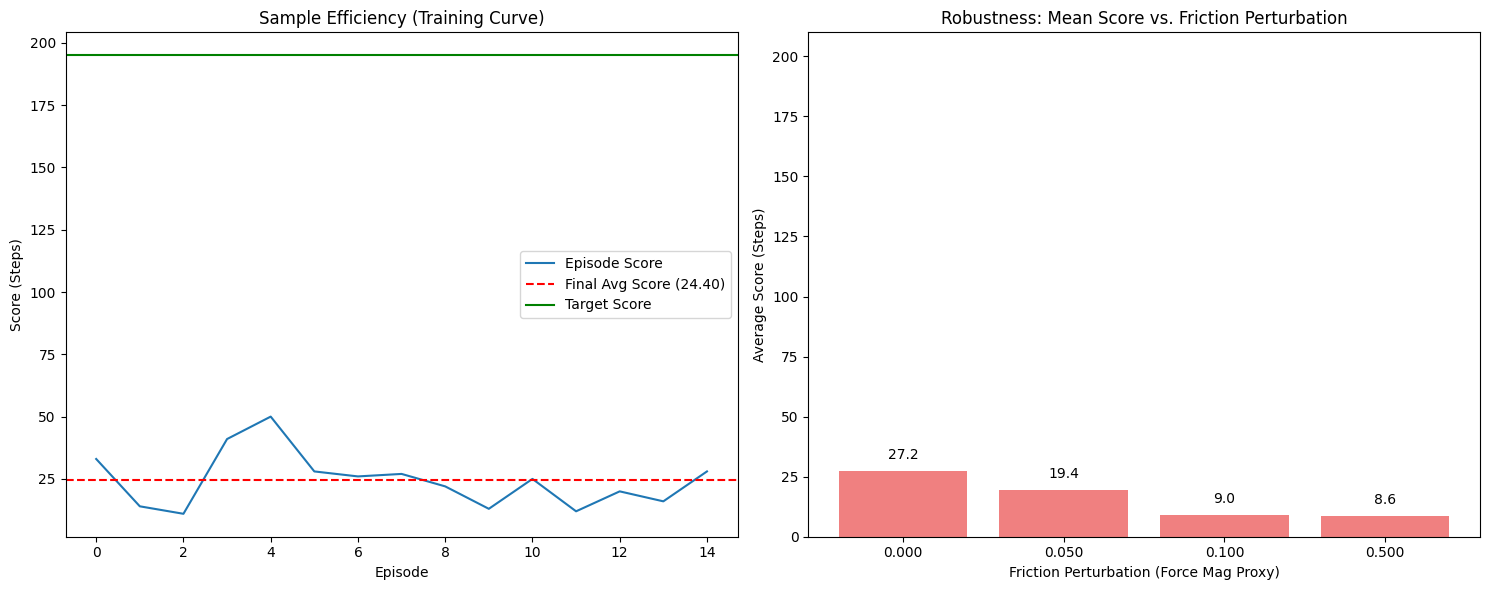


--- Starting Final Performance Visualization (Friction=0.0) ---


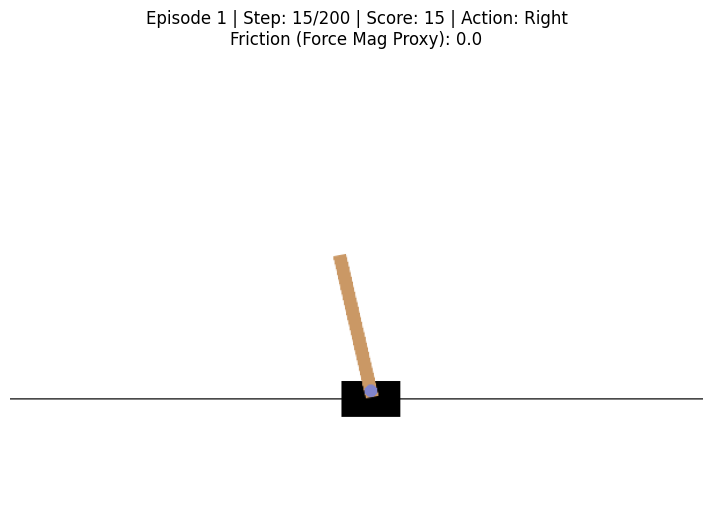

Episode 1 finished after 15 steps with score 15.
Final Performance Visualization finished.

Concept Verification System Finished.


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import time
import gym
from collections import deque
import matplotlib.pyplot as plt
from IPython import display
import os
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Set backend for interactive display in Notebook
%matplotlib inline

# --- 1. Custom CartPole Environment ---

class CustomCartPole(gym.Wrapper):
    """
    A wrapper for CartPole environment that allows modifying physical parameters.
    We simulate friction/damping by modifying 'force_mag'.
    """
    def __init__(self, env, friction_coef=None, pole_mass=None, cart_mass=None):
        super().__init__(env)
        self.friction_coef = friction_coef
        self.pole_mass = pole_mass
        self.cart_mass = cart_mass

        # NOTE: Increase 'force_mag' to simulate a harder-to-push system (greater damping/friction)
        self.friction_name = 'force_mag'
        self.pole_mass_name = 'masspole'
        self.cart_mass_name = 'masscart'

    def reset(self, **kwargs):
        # Safely handle the change in the gym API for reset()
        reset_result = self.env.reset(**kwargs)

        if isinstance(reset_result, tuple) and len(reset_result) == 2:
            observation, info = reset_result
        else:
            observation = reset_result
            info = {}  # Old API compatibility

        # Modify physics parameters
        unwrapped_env = self.env.unwrapped

        if self.friction_coef is not None and hasattr(unwrapped_env, self.friction_name):
            # Increase base force 10.0, then add additional force based on coefficient to simulate friction
            unwrapped_env.force_mag = 10.0 + self.friction_coef * 100

        if self.pole_mass is not None and hasattr(unwrapped_env, self.pole_mass_name):
            setattr(unwrapped_env, self.pole_mass_name, self.pole_mass)

        if self.cart_mass is not None and hasattr(unwrapped_env, self.cart_mass_name):
            setattr(unwrapped_env, self.cart_mass_name, self.cart_mass)

        return observation, info

    def step(self, action):
        # Safely handle the change in the gym API for step()
        step_result = self.env.step(action)

        if len(step_result) == 5:
            # New API: (obs, reward, terminated, truncated, info)
            return step_result
        elif len(step_result) == 4:
            # Old API: (obs, reward, done, info) -> We need to separate 'done' into terminated/truncated
            obs, reward, done, info = step_result
            terminated = done
            truncated = False # Assuming old 'done' is usually 'terminated'
            return obs, reward, terminated, truncated, info
        else:
            raise ValueError("Unexpected number of values returned by env.step()")


# --- 2. Minimal RSSM/Dreamer + OBJECT SLOTS Core Modules ---

# Define the device
DEVICE = torch.device("cpu") # Keep using CPU for environment consistency

# Hyperparameters
RSSM_HIDDEN_SIZE = 32
LATENT_STOCH_SIZE = 4
LATENT_DETER_SIZE = 32
ACTION_SIZE = 2
OBS_SIZE = 4
PLAN_HORIZON = 5
BATCH_SIZE = 16
CHUNK_LENGTH = 10
# *** Object Slot Hyperparameters ***
NUM_SLOTS = 2 # 2 object slots: Cart and Pole
SLOT_DIM = 16 # Dimension of each object slot

# ===============================================
# === Object Slot Attention Mechanism SlotModule ===
# ===============================================

class SlotModule(nn.Module):
    """
    Conceptual Object Slot Module:
    Decomposes the full latent state (s_t || h_t) into a set of independent object slots,
    and can recombine slots back into the full latent state. Uses MLP to simulate attention mechanism.
    """
    def __init__(self, full_state_dim, num_slots, slot_dim):
        super().__init__()
        self.num_slots = num_slots
        self.slot_dim = slot_dim
        self.full_state_dim = full_state_dim

        # 1. Encoder (Attention Mechanism Proxy): Decompose full latent state into slots
        self.slot_encoder = nn.Sequential(
            nn.Linear(full_state_dim, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, num_slots * slot_dim) # Output flattened representation of all slots
        )

        # 2. Decoder: Recombine slots back into full latent state
        self.slot_decoder = nn.Sequential(
            nn.Linear(num_slots * slot_dim, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, full_state_dim)
        )

    def forward(self, combined_state):
        """
        Input: (B, full_state_dim) - Full RSSM latent state s_t || h_t
        Output: (B, num_slots, slot_dim) - Slot representations
        """
        # (B, full_state_dim) -> (B, num_slots * slot_dim)
        flat_slots = self.slot_encoder(combined_state)

        # (B, num_slots * slot_dim) -> (B, num_slots, slot_dim)
        slots = flat_slots.view(-1, self.num_slots, self.slot_dim)

        return slots

    def recombine(self, slots):
        """
        Input: (B, num_slots, slot_dim) - Slot representations
        Output: (B, full_state_dim) - Recombined full latent state
        """
        # (B, num_slots, slot_dim) -> (B, num_slots * slot_dim)
        flat_slots = slots.view(-1, self.num_slots * self.slot_dim)

        # (B, num_slots * slot_dim) -> (B, full_state_dim)
        recombined_state = self.slot_decoder(flat_slots)

        return recombined_state

# ===============================================
# === Modified WorldModel (Integrated with Object Slots) ===
# ===============================================

class MinimalRSSM(nn.Module):
    """Simplified Recurrent State-Space Model."""
    def __init__(self):
        super().__init__()
        # Deterministic State Recurrence (h_t -> h_t+1)
        self.gru = nn.GRUCell(LATENT_STOCH_SIZE + ACTION_SIZE, LATENT_DETER_SIZE)

        # Prior/Transition Model (h_t+1 -> s_t+1)
        self.prior_mlp = nn.Sequential(
            nn.Linear(LATENT_DETER_SIZE, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, 2 * LATENT_STOCH_SIZE)
        )

    def forward(self, h, s, a):
        gru_input = torch.cat([s, a], dim=-1)
        h_next = self.gru(gru_input, h)

        prior_params = self.prior_mlp(h_next)
        mean, log_std = torch.chunk(prior_params, 2, dim=-1)
        std = nn.functional.softplus(log_std) + 0.1

        prior_dist = dist.Normal(mean, std)
        s_next = prior_dist.rsample()

        return h_next, s_next, prior_dist

class ObjectSlotWorldModel(nn.Module):
    """World Model that uses object slots to decompose and reconstruct RSSM latent states."""
    def __init__(self):
        super().__init__()
        self.rssm = MinimalRSSM()
        self.full_state_dim = LATENT_STOCH_SIZE + LATENT_DETER_SIZE

        # *** Object Slot Module ***
        self.slot_module = SlotModule(self.full_state_dim, NUM_SLOTS, SLOT_DIM)

        # Observation Decoder (Reconstructs o_t from recombined state)
        self.decoder = nn.Sequential(
            nn.Linear(self.full_state_dim, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, OBS_SIZE)
        )

        # Reward Model (Predicts r_t from recombined state)
        self.reward_model = nn.Sequential(
            nn.Linear(self.full_state_dim, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, 1)
        )

        # Encoder (o_t -> s_t) - Unchanged, processes global observation
        self.encoder = nn.Sequential(
            nn.Linear(OBS_SIZE, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, 2 * LATENT_STOCH_SIZE)
        )

    def transition(self, h, s, a):
        """Standard RSSM transition function for planning."""
        return self.rssm(h, s, a)

    def get_loss(self, actions, obs, rewards):
        """
        ELBO loss calculation including object slot reconstruction loss:
        (Object Slot Reconstruction Loss) + Reconstruction Loss + Reward Loss + KL Divergence
        """
        batch_size = obs.shape[1]

        h_t = torch.zeros(batch_size, LATENT_DETER_SIZE, device=DEVICE)
        s_t = torch.zeros(batch_size, LATENT_STOCH_SIZE, device=DEVICE)

        total_rec_loss = 0
        total_rew_loss = 0
        total_kl_loss = 0
        # *** New object slot loss term ***
        total_slot_rec_loss = 0

        for t in range(CHUNK_LENGTH - 1):
            o_t_plus_1 = obs[t+1]
            a_t = actions[t]
            r_t_plus_1 = rewards[t+1]

            # 1. Encode Observation (Posterior)
            posterior_params = self.encoder(o_t_plus_1)
            mean_post, log_std_post = torch.chunk(posterior_params, 2, dim=-1)
            std_post = nn.functional.softplus(log_std_post) + 0.1
            posterior_dist = dist.Normal(mean_post, std_post)
            s_t_post = posterior_dist.rsample() # St+1_posterior

            # 2. Transition (Prior)
            gru_input = torch.cat([s_t_post, a_t], dim=-1)
            h_t_plus_1 = self.rssm.gru(gru_input, h_t)

            # 3. Prior Model
            prior_params = self.rssm.prior_mlp(h_t_plus_1)
            mean_prior, log_std_prior = torch.chunk(prior_params, 2, dim=-1)
            std_prior = nn.functional.softplus(log_std_prior) + 0.1
            prior_dist = dist.Normal(mean_prior, std_prior) # St+1_prior

            # 4. Losses based on latent state [s_t_post, h_t_plus_1]
            original_combined_state = torch.cat([s_t_post, h_t_plus_1], dim=-1)

            # --- Object Slot Operations ---
            # a. Decomposition: Decompose latent state into slots
            slots = self.slot_module(original_combined_state) # (B, NUM_SLOTS, SLOT_DIM)

            # b. Recombination: Recombine slots back into latent state
            recombined_state = self.slot_module.recombine(slots) # (B, full_state_dim)

            # c. Object Slot Reconstruction Loss: Force recombined state to be close to original state
            # Note: detach() ensures slot_encoder only learns decomposition and doesn't affect gradient flow to RSSM states.
            slot_rec_loss = torch.mean((recombined_state - original_combined_state.detach())**2)
            total_slot_rec_loss += slot_rec_loss
            # --- Loss Calculation ---

            # Reconstruction Loss (using recombined state for reconstruction)
            predicted_obs = self.decoder(recombined_state)
            rec_loss = torch.mean((predicted_obs - o_t_plus_1)**2)

            # Reward Loss (using recombined state for prediction)
            predicted_reward = self.reward_model(recombined_state)
            rew_loss = torch.mean((predicted_reward - r_t_plus_1)**2)

            # KL Divergence
            kl_loss = dist.kl_divergence(posterior_dist, prior_dist).mean()

            total_rec_loss += rec_loss
            total_rew_loss += rew_loss
            total_kl_loss += kl_loss

            # Update state for next step
            h_t = h_t_plus_1.detach()
            s_t = s_t_post.detach()

        # Scale the KL term (beta value in ELBO) and object slot loss (alpha value)
        return total_rec_loss + total_rew_loss + 0.1 * total_kl_loss + 1.0 * total_slot_rec_loss

# ===============================================
# === 3. Minimal Actor-Critic (Using Recombined State) ===
# ===============================================

class MinimalActor(nn.Module):
    """Actor (Policy) network."""
    def __init__(self, slot_module):
        super().__init__()
        # Actor/Critic receive slot_module as they use recombined state for decision making
        self.slot_module = slot_module
        self.model = nn.Sequential(
            nn.Linear(LATENT_STOCH_SIZE + LATENT_DETER_SIZE, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, ACTION_SIZE)
        )

    def forward(self, h, s):
        # Use slots to compute state to leverage object information
        combined_state = torch.cat([s, h], dim=-1) # Note order s||h
        slots = self.slot_module(combined_state)
        recombined_state = self.slot_module.recombine(slots) # Use recombined state

        return dist.Categorical(logits=self.model(recombined_state))

class MinimalCritic(nn.Module):
    """Critic (Value) network."""
    def __init__(self, slot_module):
        super().__init__()
        self.slot_module = slot_module
        self.model = nn.Sequential(
            nn.Linear(LATENT_STOCH_SIZE + LATENT_DETER_SIZE, RSSM_HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(RSSM_HIDDEN_SIZE, 1)
        )

    def forward(self, h, s):
        # Use slots to compute state to leverage object information
        combined_state = torch.cat([s, h], dim=-1) # Note order s||h
        slots = self.slot_module(combined_state)
        recombined_state = self.slot_module.recombine(slots) # Use recombined state

        return self.model(recombined_state)

# ===============================================
# === 4. Latent Space Planner (Model Predictive Control) ===
# ===============================================

class LatentPlanner:
    """Simplified Latent Space Planner (Model Predictive Control)."""
    def __init__(self, world_model, actor, critic, horizon=PLAN_HORIZON, gamma=0.99):
        self.wm = world_model
        self.actor = actor
        self.critic = critic
        self.horizon = horizon
        self.gamma = gamma
        self.action_size = ACTION_SIZE
        self.device = DEVICE

    @torch.no_grad()
    def plan_action(self, obs, num_candidates=5):
        """
        Simulates the MPC step using random action sequences (Monte Carlo search).
        """
        start_time = time.perf_counter()

        # 1. Encode current observation to initial latent state (s_0, h_0)
        h_0 = torch.zeros(1, LATENT_DETER_SIZE, device=self.device)

        # Get posterior state s_0
        obs_tensor = torch.from_numpy(obs).float().to(self.device).unsqueeze(0)
        posterior_params = self.wm.encoder(obs_tensor)
        mean, log_std = torch.chunk(posterior_params, 2, dim=-1)
        std = nn.functional.softplus(log_std) + 0.1
        posterior_dist = dist.Normal(mean, std)
        s_0 = posterior_dist.sample()

        best_return = -float('inf')
        best_action = None

        # Random Search for the best first action
        for _ in range(num_candidates):
            h_t, s_t = h_0.clone(), s_0.clone()
            current_return = 0
            discount = 1.0
            first_action = None

            # 2. Rollout (Imagination) for H steps
            for t in range(self.horizon):
                # Sample action from actor (policy)
                action_dist = self.actor(h_t, s_t)
                action_idx = action_dist.sample()
                a_t = torch.zeros(1, self.action_size, device=self.device)
                a_t[0, action_idx] = 1.0

                if t == 0:
                    first_action = action_idx.item()

                # Predict next state using World Model
                h_t_next, s_t_next, _ = self.wm.rssm(h_t, s_t, a_t)

                # Recombine state for reward prediction
                combined_state = torch.cat([s_t_next, h_t_next], dim=-1)
                slots = self.wm.slot_module(combined_state)
                recombined_state = self.wm.slot_module.recombine(slots)

                predicted_reward = self.wm.reward_model(recombined_state)

                current_return += discount * predicted_reward.squeeze().item()
                discount *= self.gamma

                h_t, s_t = h_t_next, s_t_next

            # 3. Add terminal value estimate from Critic
            value_estimate = self.critic(h_t, s_t).squeeze().item()
            current_return += discount * value_estimate

            # 4. Select the action
            if current_return > best_return:
                best_return = current_return
                best_action = first_action

        end_time = time.perf_counter()
        planning_latency_ms = (end_time - start_time) * 1000

        return best_action if best_action is not None else np.random.randint(self.action_size), planning_latency_ms

# ===============================================
# === 5. Data Structures and Utilities (Experience Buffer) ===
# ===============================================

class ExperienceBuffer:
    """Minimal experience buffer for sequence sampling."""
    def __init__(self, capacity, obs_shape, action_size, chunk_length):
        self.capacity = capacity
        self.chunk_length = chunk_length
        self.obs = np.zeros((capacity, *obs_shape), dtype=np.float32)
        self.actions = np.zeros((capacity, action_size), dtype=np.float32)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.idx = 0
        self.size = 0

    def add(self, obs, action, reward):
        self.obs[self.idx] = obs
        one_hot_action = np.zeros(self.actions.shape[-1], dtype=np.float32)
        one_hot_action[action] = 1.0
        self.actions[self.idx] = one_hot_action
        self.rewards[self.idx] = reward
        self.idx = (self.idx + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample_chunk(self, batch_size):
        """Samples a batch of random, continuous chunks."""
        if self.size < self.chunk_length:
            return None

        max_start_idx = self.size - self.chunk_length
        if max_start_idx <= 0:
            return None

        start_indices = np.random.randint(0, max_start_idx, size=batch_size)

        batch_obs = np.array([self.obs[i:i + self.chunk_length] for i in start_indices])
        batch_actions = np.array([self.actions[i:i + self.chunk_length] for i in start_indices])
        batch_rewards = np.array([self.rewards[i:i + self.chunk_length] for i in start_indices])

        # Convert to Tensors and permute to (chunk_length, batch_size, dim) for RNN processing
        to_tensor_3d = lambda x: torch.from_numpy(x).float().to(DEVICE).permute(1, 0, 2)
        to_tensor_2d = lambda x: torch.from_numpy(x).float().to(DEVICE).permute(1, 0).unsqueeze(-1)

        return {
            'obs': to_tensor_3d(batch_obs),
            'actions': to_tensor_3d(batch_actions),
            'rewards': to_tensor_2d(batch_rewards),
        }

# ===============================================
# === 6. Training Loop (Using ObjectSlotWorldModel) ===
# ===============================================

def train_rssm_slot_dreamer_poc(
    num_episodes=15,
    max_steps_per_episode=200,
    buffer_capacity=5000,
    target_score=195,
    wm_train_steps=50,
    ac_train_steps=10
):
    # Setup
    base_env = gym.make('CartPole-v1')
    env = CustomCartPole(base_env, friction_coef=0.0)

    obs_shape = env.observation_space.shape
    action_size = env.action_space.n

    # Initialize Models
    world_model = ObjectSlotWorldModel().to(DEVICE)
    # Actor/Critic receive slot_module
    actor = MinimalActor(world_model.slot_module).to(DEVICE)
    critic = MinimalCritic(world_model.slot_module).to(DEVICE)

    # Optimizers
    wm_optimizer = optim.Adam(world_model.parameters(), lr=1e-3)
    ac_optimizer = optim.Adam(list(actor.parameters()) + list(critic.parameters()), lr=1e-3)

    # Data Buffer
    buffer = ExperienceBuffer(buffer_capacity, obs_shape, action_size, CHUNK_LENGTH)
    planner = LatentPlanner(world_model, actor, critic, horizon=PLAN_HORIZON)

    # Metrics
    episode_scores = []
    scores_deque = deque(maxlen=100)
    total_steps = 0
    steps_to_target = None
    all_planning_latencies = []

    # Visualization Setup
    fig, ax = plt.subplots(figsize=(10, 5))
    display_handle = display.display(fig, display_id=True)

    print("Starting minimal RSSM/Slot-Dreamer training...")

    # Pre-fill buffer with random experience
    print("Pre-filling buffer with random experience...")
    obs, _ = env.reset(seed=int(time.time()))
    for _ in range(2 * CHUNK_LENGTH * BATCH_SIZE):
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        buffer.add(obs, action, reward)
        obs = next_obs
        if done:
            obs, _ = env.reset()
    print(f"Buffer size: {buffer.size}")


    for i_episode in range(1, num_episodes + 1):
        # --- A. Collect Experience ---
        obs, _ = env.reset()
        episode_reward = 0

        for step in range(max_steps_per_episode):

            # Agent selects action (Planning Cost measured here)
            action, latency = planner.plan_action(obs)
            all_planning_latencies.append(latency)

            # Environment Step
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition
            buffer.add(obs, action, reward)

            episode_reward += reward
            total_steps += 1
            obs = next_obs

            if done:
                break

        # --- B. Train World Model (WM) ---
        wm_loss_log = 0
        for _ in range(wm_train_steps):
            batch = buffer.sample_chunk(BATCH_SIZE)
            if batch is None: break

            wm_optimizer.zero_grad()
            # Use new wm.get_loss
            wm_loss = world_model.get_loss(batch['actions'], batch['obs'], batch['rewards'])
            wm_loss.backward()
            wm_optimizer.step()
            wm_loss_log += wm_loss.item()

        # --- C. Train Actor/Critic (AC) on Imagination (Conceptual) ---
        ac_loss_log = 0
        for _ in range(ac_train_steps):
            batch = buffer.sample_chunk(BATCH_SIZE)
            if batch is None: break

            o_0 = batch['obs'][0]

            # Encode o_0 to get s_0 (posterior)
            posterior_params = world_model.encoder(o_0)
            mean, log_std = torch.chunk(posterior_params, 2, dim=-1)
            std = nn.functional.softplus(log_std) + 0.1
            s_t = dist.Normal(mean, std).rsample()
            h_t = torch.zeros(BATCH_SIZE, LATENT_DETER_SIZE, device=DEVICE)

            # Rollout policy gradient path for PLAN_HORIZON
            imagined_rewards = []

            for t in range(PLAN_HORIZON):
                # Actor internally includes slot recombination
                action_dist = actor(h_t, s_t)
                a_t = action_dist.sample()
                a_t_onehot = torch.zeros(BATCH_SIZE, ACTION_SIZE, device=DEVICE)
                a_t_onehot.scatter_(1, a_t.unsqueeze(1), 1)

                h_t_next, s_t_next, _ = world_model.rssm(h_t, s_t, a_t_onehot)

                # Recombine state for reward prediction
                combined_state = torch.cat([s_t_next, h_t_next], dim=-1)
                slots = world_model.slot_module(combined_state)
                recombined_state = world_model.slot_module.recombine(slots)
                predicted_reward = world_model.reward_model(recombined_state)

                imagined_rewards.append(predicted_reward)

                # IMPORTANT: Use next state for next step, but detach for policy gradient flow
                h_t = h_t_next.detach()
                s_t = s_t_next.detach()

            # Calculate V-target (Conceptual) - Simplified Lambda Return
            imagined_rewards = torch.stack(imagined_rewards, dim=0).squeeze(-1) # (PLAN_HORIZON, BATCH_SIZE)

            # Critic evaluates V(h_H, s_H)
            value_prediction_at_H = critic(h_t_next, s_t_next).squeeze(-1)

            v_target = value_prediction_at_H.detach()

            # Calculate Lambda Return backwards
            returns = [v_target]
            for r in reversed(imagined_rewards):
                v_target = r + 0.99 * v_target
                returns.append(v_target)

            estimated_return = returns[-1]

            # Actor Loss (Policy Gradient)
            actor_loss = -torch.mean(estimated_return)

            # Critic Loss (Value Prediction) - Predict V(h_H, s_H) towards estimated_return
            # Note: A proper implementation would require V-predictions for all intermediate steps
            # Here we simplify by only using the final state and return.
            value_prediction = critic(h_t_next, s_t_next).squeeze(-1)
            critic_loss = nn.functional.mse_loss(value_prediction, estimated_return.detach())

            ac_optimizer.zero_grad()
            total_ac_loss = actor_loss + critic_loss
            total_ac_loss.backward()
            ac_optimizer.step()
            ac_loss_log += total_ac_loss.item()

        # --- D. Log and Visualize Metrics (Refined Logging) ---
        episode_scores.append(episode_reward)
        scores_deque.append(episode_reward)
        avg_score = np.mean(scores_deque)

        # Sample Efficiency Metric
        if avg_score >= target_score and steps_to_target is None:
            steps_to_target = total_steps
            print(f"\nEnvironment solved! Steps to target: {steps_to_target}")

        if i_episode % 2 == 0:
            ax.clear()
            ax.plot(episode_scores, label='Episode Score')
            ax.plot([i for i in range(len(episode_scores))], [avg_score] * len(episode_scores), 'r--', label=f'Avg Score ({avg_score:.2f})')
            ax.axhline(y=target_score, color='g', linestyle='-', label='Target')
            ax.set_title(f'Sample Efficiency (Ep {i_episode}/{num_episodes}, Total Steps: {total_steps})')
            ax.set_xlabel('Episode')
            ax.set_ylabel('Score (Steps)')
            ax.legend()
            display_handle.update(fig)

            # CRITICAL REFINED LOG LINE
            print(f"Ep {i_episode}/{num_episodes}\tEpisode Score: {episode_reward:.0f}\tAvg Score: {avg_score:.2f}\tWM Loss: {wm_loss_log/wm_train_steps:.4f}")

    env.close()
    plt.close(fig)
    print("\nTraining complete.")

    final_avg_latency = np.mean(all_planning_latencies) if all_planning_latencies else 0.0

    return world_model, actor, critic, total_steps, steps_to_target, episode_scores, final_avg_latency

# ===============================================
# === 7. Metric Visualization Functions ===
# ===============================================

def test_robustness(planner, friction_coefficients=[0.0, 0.05, 0.1, 0.5], num_episodes=5):
    """Robustness: Success on perturbation sets (Friction)"""
    robustness_results = {}

    print("\nStarting Robustness Test...")
    fig_rob, ax_rob = plt.subplots(figsize=(10, 5))
    display_handle_rob = display.display(fig_rob, display_id=True)

    for i, friction in enumerate(friction_coefficients):
        base_env = gym.make('CartPole-v1')
        env = CustomCartPole(base_env, friction_coef=friction)
        scores = []

        for ep in range(num_episodes):
            obs, _ = env.reset(seed=ep)
            score = 0
            for _ in range(env.spec.max_episode_steps):
                action, _ = planner.plan_action(obs)
                next_obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                score += reward
                obs = next_obs
                if done: break
            scores.append(score)

        mean_score = np.mean(scores)
        robustness_results[friction] = {'mean_score': mean_score}

        # Update Plot
        processed_frictions = list(robustness_results.keys())
        mean_scores = [r['mean_score'] for r in robustness_results.values()]

        ax_rob.clear()
        ax_rob.bar([f'{f:.3f}' for f in processed_frictions], mean_scores, color='skyblue')
        ax_rob.set_title(f'Robustness Test: Mean Score vs. Friction (Completed {i+1}/{len(friction_coefficients)})')
        ax_rob.set_xlabel('Friction Perturbation (Force Mag Proxy)')
        ax_rob.set_ylabel('Average Score (Steps)')
        ax_rob.set_ylim(0, 210)
        for idx, score in enumerate(mean_scores):
            ax_rob.text(idx, score + 5, f'{score:.1f}', ha='center')
        display_handle_rob.update(fig_rob)

        env.close()

    plt.close(fig_rob)
    print("Robustness Test complete.")
    return robustness_results

def visualize_metrics(steps_to_target, episode_scores, robustness_results, avg_latency):
    """Summary visualization of all metrics."""
    print("\n--- Final Metrics Summary ---")

    # 1. Sample Efficiency (Text)
    print(f"Sample Efficiency (Steps to Target Score 195): {'N/A' if steps_to_target is None else steps_to_target}")

    # 2. Planning Cost (Text)
    print(f"Planning Cost (Per-step inference latency): {avg_latency:.3f} ms")

    # 3. Robustness (Text)
    print("Robustness Results (Mean Score):")
    for friction, result in robustness_results.items():
        print(f"    Friction {friction:.3f}: {result['mean_score']:.2f}")

    # Plot final Sample Efficiency Curve
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Left plot: Sample Efficiency
    axes[0].plot(episode_scores, label='Episode Score')
    avg_100 = np.mean(episode_scores[-100:] if len(episode_scores) >= 100 else episode_scores)
    axes[0].axhline(y=avg_100,
                    color='r', linestyle='--', label=f'Final Avg Score ({avg_100:.2f})')
    axes[0].axhline(y=195, color='g', linestyle='-', label='Target Score')
    axes[0].set_title('Sample Efficiency (Training Curve)')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Score (Steps)')
    axes[0].legend()

    # Right plot: Robustness
    frictions = [f'{f:.3f}' for f in robustness_results.keys()]
    mean_scores = [r['mean_score'] for r in robustness_results.values()]
    axes[1].bar(frictions, mean_scores, color='lightcoral')
    axes[1].set_title('Robustness: Mean Score vs. Friction Perturbation')
    axes[1].set_xlabel('Friction Perturbation (Force Mag Proxy)')
    axes[1].set_ylabel('Average Score (Steps)')
    axes[1].set_ylim(0, 210)

    for idx, score in enumerate(mean_scores):
        axes[1].text(idx, score + 5, f'{score:.1f}', ha='center')

    plt.tight_layout()
    display.display(fig)
    plt.close(fig)

# ===============================================
# === 8. NEW: Final Performance Visualization ===
# ===============================================

def visualize_final_performance(planner, num_episodes=1, max_steps=200, friction_coef=0.0):
    """
    Renders the trained model playing the CartPole game for a visual demonstration.
    """
    print(f"\n--- Starting Final Performance Visualization (Friction={friction_coef}) ---")

    # Create the environment with render mode and apply custom wrapper
    try:
        base_env = gym.make('CartPole-v1', render_mode='rgb_array')
    except gym.error.DependencyNotInstalled:
        print("Warning: 'rgb_array' render mode is not available. Cannot visualize. Skipping.")
        return

    # Use the CustomCartPole from the main script (which perturbs 'force_mag')
    env = CustomCartPole(base_env, friction_coef=friction_coef)

    # Setup plotting for rendering
    fig, ax = plt.subplots(figsize=(10, 6))
    display_handle = display.display(fig, display_id=True)

    for i_episode in range(num_episodes):
        obs, info = env.reset(seed=int(time.time()) + i_episode)
        total_reward = 0

        for step in range(max_steps):
            # 1. Agent selects action using the trained planner
            action, _ = planner.plan_action(obs)
            action_str = "Left" if action == 0 else "Right"

            # 2. Environment Step
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            total_reward += reward
            obs = next_obs

            # 3. Render and Update Plot
            try:
                img = env.render()
            except Exception as e:
                print(f"Rendering failed: {e}. Stopping visualization.")
                break

            # === Key logic to fix AttributeError and TypeError ===
            if isinstance(img, list):
                if not img:
                    # If list is empty, skip this rendering step
                    img_to_show = None
                else:
                    # Take the first NumPy array from the list
                    img_array = img[0]
            else:
                img_array = img

            # Only proceed with subsequent processing if img_array is successfully obtained
            if img_array is not None:
                if img_array.ndim == 4:
                    # Handle multi-frame NumPy array (N, H, W, C)
                    img_to_show = img_array[0]
                else:
                    # Otherwise use original image (H, W, C)
                    img_to_show = img_array
            else:
                continue # If no image, proceed directly to next loop iteration

            # ===================================

            ax.clear()
            ax.imshow(img_to_show)
            ax.set_title(f"Episode {i_episode+1} | Step: {step+1}/{max_steps} | Score: {total_reward:.0f} | Action: {action_str}\nFriction (Force Mag Proxy): {friction_coef}")
            ax.axis('off')

            display_handle.update(fig)
            time.sleep(0.01) # Slow down slightly for visualization

            if done:
                print(f"Episode {i_episode+1} finished after {step+1} steps with score {total_reward:.0f}.")
                break

    env.close()
    plt.close(fig)
    print("Final Performance Visualization finished.")

# ===============================================
# === 9. Execution ===
# ===============================================

if __name__ == '__main__':
    # Set number of episodes for PoC run
    NUM_EPISODES_POC = 15

    # 1. Train Minimal RSSM/Slot-Dreamer
    wm, actor, critic, total_steps, steps_to_target, episode_scores, avg_latency = \
        train_rssm_slot_dreamer_poc(num_episodes=NUM_EPISODES_POC)

    # 2. Latent Planner for evaluation
    planner_eval = LatentPlanner(wm, actor, critic, horizon=PLAN_HORIZON)

    # 3. Test Robustness
    ROBUSTNESS_FRICTION_COEFFICIENTS = [0.0, 0.05, 0.1, 0.5]
    robustness_results = test_robustness(planner_eval, friction_coefficients=ROBUSTNESS_FRICTION_COEFFICIENTS)

    # 4. Visualize all metrics (training curve, robustness, latency)
    visualize_metrics(steps_to_target, episode_scores, robustness_results, avg_latency)

    # 5. Visualize final model playing the game (in default environment, friction_coef=0.0)
    visualize_final_performance(planner_eval, num_episodes=1, friction_coef=0.0)

    print("\nConcept Verification System Finished.")